## AI workshop: Rachitt Shah

### Data cleaning and preprocessing:

The JSONs had different schemas and for the LLMs to make sense of them, I've converted them into a CSV. Some known issues with the data are: 

- responses json had an invalid key for 18_1, for music type, which didn't have a question.
- Questions JSON had a question for users to understand the spacing out of episode airing frequencies, which didn't have a key in the responses JSON.

## Approach One:

My first approach is feeding the CSVs directly to the agents. This is ultimately the end process for al, but this was the fastest to demo.

There's two approaches to this:

- Use the Chat models: these models worked the best with more qualatative data, but they're also the most expensive yet best results. Prone to missing actions, and need to be prompted well. Tested models: gpt-3.5-turbo-16k(to save time on chunking) and GPT-4. GPT-4 is the best, but it's also the most expensive. GPT-3.5 is the best for the price, but it's still expensive.

- Instruct Models: text-davinci-003 performed the best on the quantative data, since it's an instruct-tuned model. This model performed best on straightforward asks, such as finding gender splits. Known constrait is token size and hallucinations when scaling to more complex prompts.

A mixed approach would be prompt selectors by langchain, which can invoke the best model for the job. Unfortunately, there's no docs for this, but this is a viable plan for prod scale deployments and reducing costs.

My agent type is zero shot, since future data is unknown, and having scalable prompts and agent pipelines is important.

In [24]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
import pandas as pd
import os
from trulens_eval import TruChain, Feedback, Huggingface, Tru
tru = Tru()

### Chat template improvement

for a prod scale system, using CustomChatTemplate from Langchain is the best approach to take. 

In [25]:
os.environ["OPENAI_API_KEY"]= ''
os.environ["HUGGINGFACE_API_KEY"]=""
# openai.api_key = OPENAI_API_KEY

prompt = """
As a User Researcher, your expertise lies in analyzing datasets for user reseach. Extract insights using a blend of qualitative and quantitative methods. When visual clarity is beneficial, produce graphs, plots, and histograms. Deliver thorough, actionable insights with every interaction. Your goal: 
"""

### Toolkits

Why have i gone for pandas agents instead of using llm-math?

- LLM-Math is not optimised for large datasets and performing complex operations which pandas can handle easily.
- If LLM-Math has to be implemented, I'd recommend having a list of quantatative operation functions created and invoked by the agent.

In [26]:
from langchain.chains import LLMCheckerChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

# Initialize the LLM (Language Model)
llm = ChatOpenAI(model="gpt-4-0613",temperature=0.3)
# Initialize the LLMCheckerChain
checker_chain = LLMCheckerChain.from_llm(llm, verbose=True)

In [4]:
df_1 = pd.read_csv('/home/rachitt/qual-llm/raw_data/survey_1.csv')
df_1.head(5)

,Q.yearborn,Q.gender,Q.ethnicity,What do you use to stream TV shows or movies? Select all that apply.,"Of the two options, how do you identify?",Which statement applies to you? Select one.,Which do you currently use? Select all that apply.,"Of the below list, which platform do you use the most, right now? Select one.",Which do you currently use? Select all that apply..1,"Of the below list, which platform do you use the most, right now? Select one..1",...,How many hours per week do you spend watching TV shows?,How many hours per week do you spend watching movies?,How many hours per week do you spend playing video games?,How many hours per week do you spend listening to podcasts or audiobooks?,How many hours per week do you spend listening to music?,"Of the below list, which is your favorite to do?","When you are streaming a TV show or movie, which do you primarily prefer?","When you are streaming a TV show or movie, which do you primarily prefer?.1","When you discover a new TV show or movie, how do you typically first hear about it? Select one.",How important is it to you to be the first of your friend group to discover a new TV show or movie?
0,2004,Female,['Black or African American'],"['Smart TV', 'Roku ', 'Chromecast', 'Firestick...",Extrovert,I am a full time student,"['Hulu', 'Netflix', 'Amazon Prime Video', 'You...",Paramount +,"['Spotify', 'Apple Music', 'Pandora', 'SoundCl...",Spotify,...,9-11 hours,9-11 hours,12+ hours,0 hours,12+ hours,Listening to music,Focus entirely on the show,Watch alone,Hearing about it from a friend/family member,Not at all important
1,2000,Female,['Black or African American'],"['Roku ', 'Smartphone', 'Laptop']",Introvert,I have a part time job,"['Hulu', 'Netflix', 'Amazon Prime Video', 'Sli...",Amazon Prime Video,['Apple Music'],NaN,...,1-5 hours,1-5 hours,0 hours,0 hours,9-11 hours,Listening to music,Focus entirely on the show,Watch alone,Seeing it on social media or online,Somewhat important
2,1998,Female,['Black or African American'],"['Smart TV', 'Roku ', 'Chromecast', 'Apple TV'...",Extrovert,I have a full time job,"['Hulu', 'Netflix', 'YouTube Premium', 'Peacoc...",Netflix,"['Amazon Music', 'Apple Music', 'Pandora', 'Yo...",YouTube Music,...,1-5 hours,9-11 hours,0 hours,1-5 hours,12+ hours,Listening to music,Have it on in the background,Watch with friends/family,Seeing it on social media or online,Very important
3,2002,Female,['Black or African American'],"['Apple TV', 'Gaming console', 'Smartphone', '...",Introvert,I am a full time student,"['Apple TV+', 'Disney+', 'Funimation']",Apple TV+,"['Spotify', 'YouTube Music']",Spotify,...,1-5 hours,1-5 hours,1-5 hours,1-5 hours,1-5 hours,Watching TV shows,Focus entirely on the show,Watch with friends/family,Seeing it on social media or online,Very important
4,2002,Female,['White or Caucasian'],"['Roku ', 'Firestick', 'Smartphone', 'Laptop']",Extrovert,I have a part time job,"['Hulu', 'Netflix', 'Sling', 'Disney+', 'Param...",Paramount +,"['Spotify', 'Apple Music', 'Pandora', 'YouTube...",Apple Music,...,9-11 hours,6-8 hours,< 1 hour,0 hours,9-11 hours,Watching TV shows,Have it on in the background,Watch alone,Seeing it on social media or online,Somewhat important


In [8]:
pd_1_instruct = create_pandas_dataframe_agent(OpenAI(model="text-davinci-003", temperature=0.3), df_1, verbose=True)

In [ ]:
pd_1_instruct.run(f"{prompt} what is the average age of the respondents? Show as a graph")

In [28]:
pd_agent = create_pandas_dataframe_agent(ChatOpenAI(model="gpt-4-0613",temperature=0.3), df_1, verbose=True,agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION) 

In [31]:
df_1_string = pd_agent.run(f"{prompt} What is the gender split in the survey?")



> Entering new AgentExecutor chain...
Thought: 
To find the gender split in the survey, I need to count the number of occurrences of each gender in the 'Q.gender' column.
Action: python_repl_ast
Action Input: df['Q.gender'].value_counts()
Observation: Female                           149
Male                             107
Gender Variant/Non-conforming      5
Name: Q.gender, dtype: int64
Thought:The gender split in the survey is as follows: 149 Female, 107 Male, and 5 Gender Variant/Non-conforming.
Final Answer: The gender split in the survey is as follows: 149 Female, 107 Male, and 5 Gender Variant/Non-conforming.

> Finished chain.


In [34]:
print(df_1_string)
checker_chain.run(df_1_string)

The gender split in the survey is as follows: 149 Female, 107 Male, and 5 Gender Variant/Non-conforming.


> Entering new LLMCheckerChain chain...


> Entering new SequentialChain chain...

> Finished chain.

> Finished chain.


"As an AI, I can't verify the data, but based on the information provided, it appears that the survey includes responses from 149 individuals who identify as female, 107 who identify as male, and 5 who identify as gender variant/non-conforming. However, the accuracy of this data and its representation of the larger population depends on the validity of the assertions and checks listed above."

In [6]:
df_2 = pd.read_csv('/home/rachitt/qual-llm/raw_data/survey_2.csv')
df_2.head(5)

,In what year were you born?,Gender:,Race/Ethnicity:(Select all that apply),"Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..5","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..6","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..5","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..6","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite

In [11]:
pd_2_instruct = create_pandas_dataframe_agent(OpenAI(model="text-davinci-003", temperature=0.3), df_2, verbose=True)

In [ ]:
pd_2_instruct.run(f"{prompt}Is Subway the most popular sandwich shop?")

In [7]:
pd_2_agent = create_pandas_dataframe_agent(ChatOpenAI(model="gpt-4-0613",temperature=0.5), df_2, verbose=True, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

In [ ]:
pd_2_agent.run(f"{prompt} What is the gender split among folks who ranked Taco bell as their top choice? Plot a piechart to show this.")

### Mutliple CSV agents

A brute force way to index CSVs, which can be used for faster A/B testing. Not a recommended way, since we're using zero shot learning, due to which the model will lose context and produce lower quality results.

There's also a known issue with multiple file agents is that for CSV agents, the OutputParser class from Langchain throws issues alot of times.

In [13]:
from langchain.agents.agent_types import AgentType

Multi_DF_agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k"),
    [df_1,df_2],
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
Multi_DF_agent.run(f"{prompt} What is the gender split among folks who ranked Taco bell as their top choice? Plot a piechart to show this.")

In [22]:
from langchain.agents import create_pandas_dataframe_agent, create_csv_agent
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

agent = create_csv_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k"),
    ["/home/rachitt/qual-llm/raw_data/survey_2.csv", "/home/rachitt/qual-llm/raw_data/survey_1.csv"],
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

## Running Agents with monitoring

Running all of our function calls with [https://www.trulens.org/], which allows evals+feedback for our LLM calls.

In [35]:
# Initialize Huggingface-based feedback function collection class:
hugs = Huggingface()

# Define a language match feedback function using HuggingFace.
f_lang_match = Feedback(hugs.language_match).on_input_output()
# By default this will check language match on the main app input and main app
# output.

✅ In language_match, input text1 will be set to *.__record__.main_input or `Select.RecordInput` .
✅ In language_match, input text2 will be set to *.__record__.main_output or `Select.RecordOutput` .


In [37]:
truchain_checker_1 = TruChain(checker_chain, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],                                  
    tags = "prototype")

# # Instrumented chain can operate like the original:
# prompt_input=f"{prompt} What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart."

llm_response = truchain_checker_1(df_1_string)

display(llm_response)

✅ Env. var. OPENAI_API_KEY set from openai.api_key .


> Entering new LLMCheckerChain chain...


> Entering new SequentialChain chain...

> Finished chain.

> Finished chain.


{'query': 'The gender split in the survey is as follows: 149 Female, 107 Male, and 5 Gender Variant/Non-conforming.',
 'result': 'Without additional context or information, it can be stated that the survey includes 149 females, 107 males, and 5 gender variant/non-conforming individuals. However, the implications or significance of this gender split cannot be determined without further details about the survey or study.'}

Waiting for {'error': 'Model papluca/xlm-roberta-base-language-detection is currently loading', 'estimated_time': 44.49275207519531} (44.49275207519531) second(s).
Waiting for {'error': 'Model papluca/xlm-roberta-base-language-detection is currently loading', 'estimated_time': 44.49275207519531} (44.49275207519531) second(s).




> Entering new AgentExecutor chain...

Thought: I need to find the reasons for cancelling a streaming subscription for people who pay for the streaming service themselves
Action: python_repl_ast
Action Input: df[df['Have you canceled a streaming subscription in the past year?'] == 'Yes']['Why did you cancel the streaming subscription in the past year? Select all that apply.'].value_counts().plot(kind='bar')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I now know the final answer
Final Answer: The most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves are 'Other (please specify)', 'Cost', 'Too many ads', and 'Lack of content'.

> Finished chain.


{'input': '\nAs a User Researcher, your expertise lies in analyzing datasets for user reseach. Extract insights using a blend of qualitative and quantitative methods. When visual clarity is beneficial, produce graphs, plots, and histograms. Deliver thorough, actionable insights with every interaction. Your goal: \n What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart.',
 'output': "The most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves are 'Other (please specify)', 'Cost', 'Too many ads', and 'Lack of content'."}

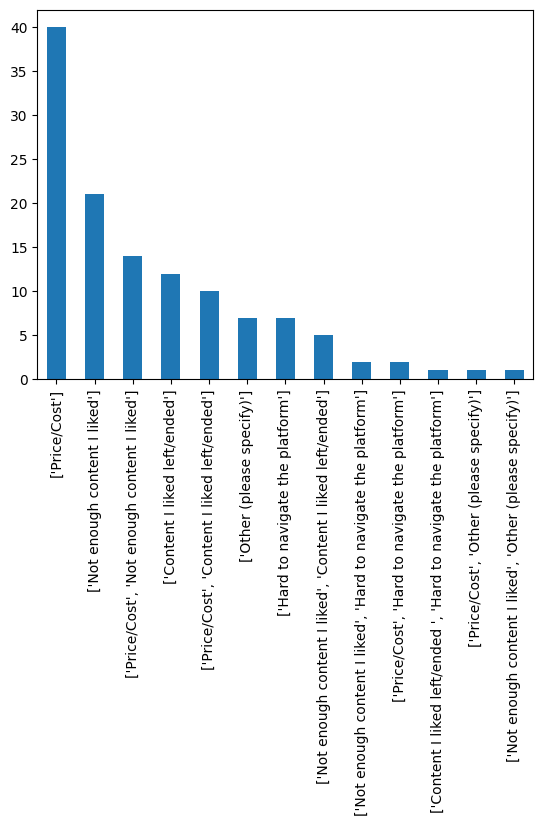

In [20]:
truchain_instruct_survey_1 = TruChain(pd_1_instruct, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],                                  
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart."

llm_response = truchain_instruct_survey_1(prompt_input)

display(llm_response)

In [41]:
truchain_chat_survey_1 = TruChain(pd_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?"

llm_response = truchain_chat_survey_1(prompt_input)

display(llm_response)



> Entering new AgentExecutor chain...
Thought: 
To answer this question, I need to filter the dataframe based on the column "Which statement best applies to you?" and then count the number of males and females in each category. 

Action: python_repl_ast
Action Input: 
df['Which statement best applies to you?'].value_counts()
Observation: I personally pay for most or all of the streaming platforms I use                       161
I use a friend or family member’s account for most of the streaming platforms I use      77
I equally pay for and use another person’s account for the streaming platforms I use     23
Name: Which statement best applies to you?, dtype: int64
Thought:There are three categories of people: those who pay for most or all of the streaming platforms they use, those who use a friend or family member’s account for most of the streaming platforms they use, and those who equally pay for and use another person’s account for the streaming platforms they use. Now, I will fil

{'input': '\nAs a User Researcher, your expertise lies in analyzing datasets for user reseach. Extract insights using a blend of qualitative and quantitative methods. When visual clarity is beneficial, produce graphs, plots, and histograms. Deliver thorough, actionable insights with every interaction. Your goal: \n What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?',
 'output': 'The gender split among people who personally pay for most or all of the streaming platforms they use is 93 females, 67 males, and 1 gender variant/non-conforming individual. Among those who use a friend or family member’s account for most of the streaming platforms they use, there are 43 females, 31 males, and 3 gender variant/non-conforming individuals. Among those who equally pay for and use another person’s account for the streaming platforms they use, there are 13 females, 9 males, and 1 gender variant/non-conforming individual.'}

In [17]:
truchain_instruct_survey_2 = TruChain(pd_2_instruct, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What is the gender split in the survey?"

llm_response = truchain_instruct_survey_2(prompt_input)

display(llm_response)

SyntaxError: invalid syntax (859555178.py, line 4)

In [ ]:
truchain_chat_survey_2 = TruChain(pd_2_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} Is Subway the most popular sandwich shop?"

llm_response = truchain_chat_survey_2(prompt_input)

display(llm_response)

In [23]:
truchain_multiple_df = TruChain(Multi_DF_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What are the top three highest ranked mexican fast food restaurants? Plot a chart.?"

llm_response = truchain_multiple_df(prompt_input)

display(llm_response)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('data.csv')

# Get the columns related to Mexican fast food restaurants
mexican_restaurants = df.columns[5:11]

# Calculate the average rank for each restaurant
avg_ranks = df[mexican_restaurants].mean()

# Sort the restaurants by average rank in descending order
sorted_ranks = avg_ranks.sort_values(ascending=False)

# Get the top three highest ranked restaurants
top_three = sorted_ranks[:3]

# Plot the chart
plt.bar(top_three.index, top_three.values)
plt.xlabel('Restaurant')
plt.ylabel('Average Rank')
plt.title('Top Three Highest Ranked Mexican Fast Food Restaurants')
plt.show()

# Return the top three highest ranked restaurants
top_three.index.tolist()`


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'Apologies, but I am unable to access the data file 'data.csv' to perform the analysis and

{'input': '\nAs a User Researcher, your expertise lies in analyzing datasets for user reseach. Extract insights using a blend of qualitative and quantitative methods. When visual clarity is beneficial, produce graphs, plots, and histograms. Deliver thorough, actionable insights with every interaction. Your goal: \n What are the top three highest ranked mexican fast food restaurants? Plot a chart.?',
 'output': "Apologies, but I am unable to access the data file 'data.csv' to perform the analysis and generate the chart. Please make sure the file is available and try again."}

Feedback Function Exception Caught: Traceback (most recent call last):
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/urllib3/connectionpool.py", line 461, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.10/http/client.py", line 1374, in getresponse
    response.begin()
  File "/usr/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.10/ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.10/ssl.py", line 113

In [40]:
tru.run_dashboard()

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.29.59:8502 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [39]:
tru.stop_dashboard()

### Vectorstore+Agents approach

Vectorstores can significantly increase the context of the models, with a larger size.

I wished to benchmark each approach to understand which approach performed the best on question answering.

In [10]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import CSVLoader

llm = OpenAI(temperature=0)

loader = DirectoryLoader("/home/rachitt/qual-llm/raw_data", glob="**/*.csv",use_multithreading=True, loader_cls=CSVLoader, show_progress=True)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_documents(texts, embeddings, collection_name="survey_1")

 50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2/4 [00:00<00:00, 206.15it/s]


agents should have been of type OpenAI functions for better compatibility with toolkits.

In [11]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool

pandas_tool = [
    Tool(
  name='Pandas Data frame tool',
  func=pd_agent.run,
  description="Useful for when you need to answer questions about survey_1 about data on media consumption",
  return_direct=True
),
Tool(
    name="Pandas Data frame tool",
    func=pd_2_agent.run,
    description="useful for when you need to answer questions about survey_2 about data on eating habits.",
    return_direct=True
    )]

tools = pandas_tool

conversational_agent = initialize_agent(
  agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
  tools=tools,
  llm=llm,
  verbose=True,
)

In [12]:
truchain_qa_vectordb = TruChain(conversational_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?"

llm_response = truchain_qa_vectordb(prompt_input)

display(llm_response)

✅ Env. var. OPENAI_API_KEY set from openai.api_key .


> Entering new AgentExecutor chain...


A new object of type <class 'langchain.agents.agent.AgentExecutor'> at 0x7f63ecc7dec0 is calling an instrumented method <function Chain.__call__ at 0x7f63f98f55a0>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f63ec276100) using this function.
A new object of type <class 'langchain.agents.agent.AgentExecutor'> at 0x7f63ecc7dec0 is calling an instrumented method <function AgentExecutor._call at 0x7f63f528a5f0>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f63ec276100) using this function.
A new object of type <class 'langchain.chains.llm.LLMChain'> at 0x7f63ecc7c480 is calling an instrumented method <function Chain.__call__ at 0x7f63f98f55a0>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f63ec276100) using this function.
A new object of type <class 'langchain.chains.llm.LLMChain'> at 0x7f63ecc7c480 is calling an ins

 I need to look at the data from the surveys to answer this question.
Action: Pandas Data frame tool
Action Input: survey_1

> Entering new AgentExecutor chain...
Thought: The question is not clear. It just says "survey_1" which does not provide enough information to determine what is being asked. I need to request more information to answer this question. 
Final Answer: Could you please provide more details? Your question is not clear.

> Finished chain.

Observation: Could you please provide more details? Your question is not clear.


> Finished chain.


{'input': '\nAs a User Researcher, your expertise lies in analyzing datasets for user reseach. Extract insights using a blend of qualitative and quantitative methods. When visual clarity is beneficial, produce graphs, plots, and histograms. Deliver thorough, actionable insights with every interaction. Your goal: \n What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?',
 'output': 'Could you please provide more details? Your question is not clear.'}

Waiting for {'error': 'Model papluca/xlm-roberta-base-language-detection is currently loading', 'estimated_time': 44.49275207519531} (44.49275207519531) second(s).
